In [1]:
import re
import xapian
import pandas as pd
import numpy as np
import csv
import json
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.display.max_colwidth = 200
pd.options.display.precision = 2

In [4]:
DBPATH = "sentence_index"
SOURCES = ['dev', 'train', 'test']
SOURCES = ['dev']
#SOURCES = ['test']
#SOURCES = ['train']
SEARCH_RESULT_PATH = "data/search_results_v5_{}.csv".format(SOURCES[0])

In [5]:
!xapian-delve $DBPATH

UUID = 2e417945-ee51-4683-9012-a84c3edeb1a1
number of documents = 23931434
average document length = 43.0649
document length lower bound = 6
document length upper bound = 297
highest document id ever used = 23931434
has positional information = true
revision = 2412
currently open for writing = false


In [6]:
!xapian-delve -r 40000 -d $DBPATH

Data for record #40000:
{"page_id": "1950_Open_Championship", "sentence_id": 0, "shard": "001", "text": "The 1950 Open Championship was the 79th Open Championship , held 5 -- 7 July at Troon Golf Club in Troon , South Ayrshire , Scotland .", "topic": "1950 Open Championship"}
Term List for record #40000: 1950 5 7 79th Q1950_Open_Championship_0 Zat Zayrshir Zchampionship Zclub Zgolf Zheld Zin Zjuli Zopen Zscotland Zsouth Zthe Ztroon Zwas at ayrshire championship club golf held in july open scotland south the troon was


# Retrieve documents relevant to claims

In [7]:
claim_df = pd.read_json('data/claims_lm.json').sort_index()

In [8]:
mask = claim_df.source.isin(SOURCES)
claim_df = claim_df[mask]

In [9]:
claim_df.shape

(5001, 10)

In [10]:
# Prepare enquiry object

# Open the database we're going to search.
db = xapian.Database(DBPATH)

# Set up a QueryParser with a stemmer and suitable prefixes
queryparser = xapian.QueryParser()
queryparser.set_stemmer(xapian.Stem("en"))
queryparser.set_stemming_strategy(queryparser.STEM_SOME)
#queryparser.add_prefix('keywords', 'K')

# Use an Enquire object on the database to run the query
enquire = xapian.Enquire(db)    

In [11]:
%%time
fields = ['claim_id', 'found_doc', 'sentence_id', 'text', 'rank', 'percentage', 'weight']
pagesize = 50

with open(SEARCH_RESULT_PATH, 'w') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()

    for claim_id, claim in tqdm(claim_df['claim'].items(), total=claim_df.shape[0]):
        query_str = claim
        query = queryparser.parse_query(query_str)
                
        enquire.set_query(query)
        matches = enquire.get_mset(0, pagesize)

        query_results = []
        for match in matches:
            fields = json.loads(match.document.get_data())
            page_id = fields['page_id']
            sent_id = fields['sentence_id']
            text = fields['text']
            
            result = dict(
                claim_id = claim_id,
                found_doc = fields['page_id'],
                sentence_id = fields['sentence_id'],
                text = fields['text'],
                rank = match.rank + 1,
                percentage = match.percent,
                weight = match.weight,            
            )
            query_results.append(result)
        writer.writerows(query_results)
csvFile.close()

100%|██████████| 145449/145449 [12:00:02<00:00,  3.83it/s]   

CPU times: user 8h 57min 40s, sys: 2h 27min 54s, total: 11h 25min 35s
Wall time: 12h 2s


# Analyse Found Documents

## Read search results

In [10]:
import unicodedata

In [11]:
results_df = pd.read_csv(SEARCH_RESULT_PATH)
normalise = lambda item: unicodedata.normalize('NFD', item) if isinstance(item, str) else item
results_df['found_doc'] = results_df['found_doc'].apply(normalise)

In [12]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500100 entries, 0 to 500099
Data columns (total 7 columns):
claim_id       500100 non-null int64
found_doc      500100 non-null object
sentence_id    500100 non-null int64
text           500100 non-null object
rank           500100 non-null int64
percentage     500100 non-null int64
weight         500100 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 26.7+ MB


In [13]:
#results_df.sort_values('percentage', ascending=False).head(100)
results_df.sort_values('weight', ascending=False).head(10)

,claim_id,found_doc,sentence_id,text,rank,percentage,weight
226100,111251,Boylston_-LRB-MBTA_station-RRB-,0,"Boylston is a light rail station on the MBTA Green Line system , and is located on the southeast corner of Boston Common at the intersection of Boylston Street and Tremont Street .",1,91,155.87
50500,26138,Boylston_-LRB-MBTA_station-RRB-,0,"Boylston is a light rail station on the MBTA Green Line system , and is located on the southeast corner of Boston Common at the intersection of Boylston Street and Tremont Street .",1,93,135.40
123900,63575,Park_Street_-LRB-MBTA_station-RRB-,0,"Park Street is a station on the MBTA subway system , located at the intersection of Park Street and Tremont Street under Boston Common in downtown Boston .",1,96,132.14
154700,77743,Chunsa_Film_Art_Awards,2,"Prizes are given for Best Film , Best Director , Best Actor , Best Actress , Best Supporting Actor , Best Supporting Actress , Best New Director , Best New Actor , Best New Actress , Best Screenpl...",1,74,130.18
154701,77743,Germinal_-LRB-1993_film-RRB-,6,"It won the César Award for Best Cinematography and Best Costume Design , and was nominated for Best Film , Best Actress , Best Supporting Actor , Best Supporting Actress , Best director , Best Wri...",2,68,120.04
154702,77743,The_Aviator_-LRB-2004_film-RRB-,11,"It was nominated for eleven Academy Awards , including Best Picture , Best Director , Best Original Screenplay , Best Actor in a Leading Role for DiCaprio , and Best Actor in a Supporting Role for...",3,67,119.15
468700,212321,Mary-Kate_and_Ashley_Olsen,0,"Mary-Kate Olsen and Ashley Olsen -LRB- born June 13 , 1986 -RRB- , also known as the Olsen twins collectively , are American fashion designers and former child actresses .",1,93,117.29
154703,77743,True_Grit_-LRB-2010_film-RRB-,13,"It was nominated for ten Academy Awards : Best Picture , Best Director , Best Adapted Screenplay , Best Actor in a Leading Role -LRB- Bridges -RRB- , Best Actress in a Supporting Role -LRB- Steinf...",4,66,116.85
154704,77743,Thessaloniki_Festival_of_Greek_Cinema,9,"The awards comprise the categories : best film , best director , best screenplay , best editing , best cinematography , best actor , best actress , best supporting actor , best supporting actress ...",5,66,116.19
154705,77743,The_Dressmaker_-LRB-2015_film-RRB-,12,"The film led the 5th AACTA Awards with thirteen nominations , including Best Film , Best Direction , Best Production Design , Best Original Music Score , Best Sound , Best Editing , Best Cinematog...",6,65,115.52


## Read claims

In [14]:
sources = SOURCES
if 'test' in sources:
    sources.remove('test')
    
labelled_claims_df = pd.read_json('data/l_claims.json').sort_index()
mask = labelled_claims_df.source.isin(sources)
labelled_claims_df = labelled_claims_df[mask]

In [15]:
labelled_claims_df.head()

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count,evidence_set_str
12,Carlos Santana disbanded Santana in 1965.,"[[Carlos_Santana, 3], [Carlos_Santana, 0], [Carlos_Santana, 2]]",REFUTES,dev,[Carlos_Santana],1,3,{'Carlos_Santana'}
70,David Packouz was born in February of 1982.,"[[David_Packouz, 0]]",SUPPORTS,dev,[David_Packouz],1,1,{'David_Packouz'}
97,Craig David is a pop music performer.,"[[Craig_David, 2], [Craig_David, 0], [Craig_David, 5]]",SUPPORTS,dev,[Craig_David],1,3,{'Craig_David'}
98,Craig David is a performer that does pop music.,[],NOT ENOUGH INFO,dev,[],0,0,set()
158,Wish Upon was released in France.,[],NOT ENOUGH INFO,dev,[],0,0,set()


## Estimate index-search performance

In [16]:
def calculate_recall(mask):
    func = lambda x: set(x)
    found_docs_df = results_df[mask].pivot_table(index='claim_id', values='found_doc', aggfunc=func)

    recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

    def func(x):
        if isinstance(x['found_doc'], set):
            return set(x['evidence_docs']).difference(x['found_doc'])
        return set(x['evidence_docs'])

    recall_df['missed_docs'] = recall_df.apply(func, axis=1)
    recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

    recall_df = recall_df.pivot_table(index='missed_count', columns='source',# margins=True,
                                                    values='claim', aggfunc='count', fill_value=0)
    return recall_df

In [17]:
%%time

results = []
for top in range(5, 101, 5):
    #print(top)
    mask = results_df['rank'] <= top
    
    recall_df = calculate_recall(mask)
    
    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['top'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 10.2 s, sys: 513 ms, total: 10.7 s
Wall time: 10.8 s


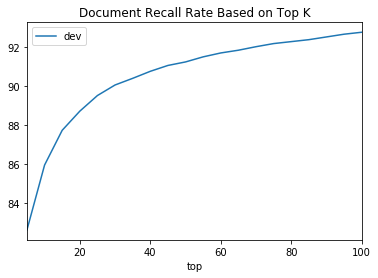

,dev
top,
5,82.62
10,85.94
15,87.72
20,88.70
25,89.50
30,90.04
35,90.38
40,90.74
45,91.04


In [18]:
df = pd.DataFrame.from_records(results).set_index('top')
df.plot.line(title='Document Recall Rate Based on Top K')
plt.show()
df#.T

In [19]:
%%time

results = []
for top in range(5, 101, 5):
    #print(top)
    mask = results_df['percentage'] >= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['percentage'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 9.54 s, sys: 470 ms, total: 10 s
Wall time: 9.96 s


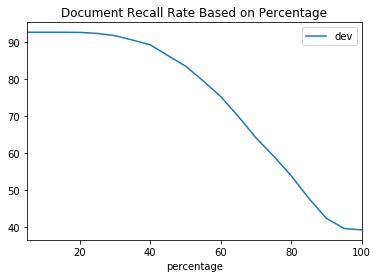

,dev
percentage,
5,92.74
10,92.74
15,92.74
20,92.70
25,92.42
30,91.82
35,90.64
40,89.34
45,86.44


In [20]:
df = pd.DataFrame.from_records(results).set_index('percentage')
df.plot.line(title='Document Recall Rate Based on Percentage')
plt.show()
df#.T

In [21]:
%%time

results = []
for top in range(10, 25, 1):
    #print(top)
    mask = results_df['weight'] >= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['weight'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 8.84 s, sys: 553 ms, total: 9.39 s
Wall time: 9.32 s


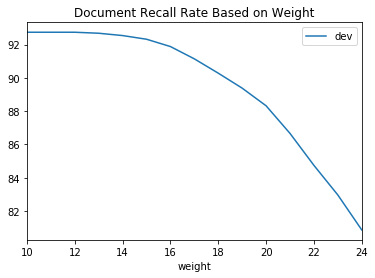

,dev
weight,
10,92.74
11,92.74
12,92.74
13,92.68
14,92.54
15,92.32
16,91.88
17,91.14
18,90.28


In [22]:
df = pd.DataFrame.from_records(results).set_index('weight')
df.plot.line(title='Document Recall Rate Based on Weight')
plt.show()
df#.T

## Search performance with filters applied

In [25]:
mask = (results_df['rank'] <= 10) #& (results_df.weight > 10) #& (results_df.percentage > 25)
recall_df = calculate_recall(mask)
recall_df = (recall_df / recall_df.sum() * 100)#.head(1)
recall_df.head(1)

source,train
missed_count,
0,81.03


In [26]:
results_df.found_doc.unique().shape[0], results_df[mask].found_doc.unique().shape[0] 

(1105927, 288927)

In [27]:
mask = (results_df['rank'] <= 25)
processed_docs = results_df[mask].found_doc.unique()
len(processed_docs)

637836

In [28]:
mask = (results_df['rank'] <= 50)
docs = results_df[mask].found_doc.unique()
len(docs)

1105927

In [29]:
docs = list(set(docs).difference(set(processed_docs)))
len(docs)

468091

In [30]:
with open('data/top_26-50_docs.json', 'w') as fp:
    json.dump(list(docs), fp)

## Prepare submission

In [31]:
mask = (results_df['rank'] <= 10) & (results_df.percentage > 25) & (results_df.weight > 15)
submission_df = results_df[mask].set_index('claim_id')[['found_doc']].join(claim_df.claim)
submission_df.head()

,found_doc,claim
3,Chris_Hemsworth,Chris Hemsworth appeared in A Perfect Getaway.
3,Chris_Hemsworth,Chris Hemsworth appeared in A Perfect Getaway.
3,Chris_Hemsworth,Chris Hemsworth appeared in A Perfect Getaway.
3,Vanessa_Zachos,Chris Hemsworth appeared in A Perfect Getaway.
3,A_Perfect_Getaway,Chris Hemsworth appeared in A Perfect Getaway.


In [32]:
results_df.shape, submission_df.shape,

((7272450, 7), (1429719, 2))

In [33]:
results_df.head()

,claim_id,found_doc,sentence_id,text,rank,percentage,weight
0,3,Chris_Hemsworth,2,"Hemsworth has also appeared in the science fiction action film Star Trek -LRB- 2009 -RRB- , the thriller adventure A Perfect Getaway -LRB- 2009 -RRB- , the horror comedy The Cabin in the Woods -LR...",1,100,31.78
1,3,Chris_Hemsworth,0,Chris Hemsworth -LRB- born 11 August 1983 -RRB- is an Australian actor .,2,80,25.45
2,3,Chris_Hemsworth,6,"The following year , Hemsworth had a supporting role in Sony 's reboot of Ghostbusters .",3,75,23.91
3,3,Vanessa_Zachos,15,Zachos was cast in a principal role opposite Chris Hemsworth in Ron Howards BAFTA nominated film Rush where she worked alongside Chris Hemsworth and Daniel Bruhl .,4,74,23.78
4,3,A_Perfect_Getaway,0,"A Perfect Getaway is a 2009 American adventure psychological thriller film , written and directed by David Twohy , that stars Timothy Olyphant , Milla Jovovich , Kiele Sanchez , and Steve Zahn .",5,74,23.72


In [34]:
results_df.found_doc.unique().shape, submission_df.found_doc.unique().shape

((1105927,), (282636,))

In [35]:
submission_df['label'] = "SUPPORTS"
submission_df['evidence'] = submission_df.found_doc.apply(lambda x: [[x, 0]])

In [36]:
del submission_df['found_doc']

In [37]:
#submission_df.to_json('testoutput.json', orient='index')

In [38]:
submission_df.shape

(1429719, 3)

## Evidence found

In [23]:
found_docs_df = results_df.pivot_table(index='claim_id', values='found_doc', aggfunc=list)
recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

def func(x):
    if isinstance(x['found_doc'], list):
        return set(x['evidence_docs']).difference(set(x['found_doc']))
    return set(x['evidence_docs'])

recall_df['missed_docs'] = recall_df.apply(func, axis=1)
recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

In [24]:
recall_df[recall_df.missed_count > 0]

,evidence_docs,source,claim,found_doc,missed_docs,missed_count
673,[Saxony],dev,Saxony is only a town.,"[Meerane_station, Schneeberg,_Saxony, Waldheim,_Saxony, Baden,_Lower_Saxony, Lichtenstein,_Saxony, Waldenburg,_Saxony, Hainichen,_Saxony, Königstein,_Saxony, Wettin, Riesa_railway_station, Arnste...",{Saxony},1
752,"[FA_Cup, Tottenham_Hotspur_F.C., EFL_Cup]",dev,Tottenham Hotspur F.C. is a football club.,"[Tottenham_Hotspur_L.F.C., History_of_Tottenham_Hotspur_F.C., Tottenham_Hotspur_F.C., Chelsea_F.C.–Tottenham_Hotspur_F.C._rivalry, Tottenham_-LRB-disambiguation-RRB-, 2010–11_Tottenham_Hotspur_F.C...","{FA_Cup, EFL_Cup}",2
1076,"[James_Jones_-LRB-basketball_player-RRB-, NBA_playoffs]",dev,James Jones missed the finals once.,"[James_Jones_-LRB-basketball_player-RRB-, James_Jones_-LRB-defensive_lineman-RRB-, James_Matthew_Jones, Miss_Texas_USA_1992, The_Vessel_of_Wrath, Miss_Robin_Hood, Robyn_MacPhee, Have_You_Met_Miss_...",{NBA_playoffs},1
2421,"[Tualatin_River, Beaverton,_Oregon]",dev,"Beaverton, Oregon's city center is in the Grand Canyon.","[Grand_Canyon_Airlines, Grand_Canyon_Village_Historic_District, Grand_Canyon_Parkway, Cedar_Hills_Crossing, Beaverton_Transit_Center, Beaverton_Corporate_Center_Heliport, Grand_Canyon_Water_Reclam...",{Tualatin_River},1
5454,[Jack_Falahee],dev,Jack Falahee's middle name is Bryan.,"[Bryan_Creed_Jack, Long_Middle_School, John_Bryan, Jack_P._Shepherd, Jack_Bryan, Jack_Bryan, Bryan_Creed_Jack, Jack_Whitt, Bryan_County,_Georgia, Jack_Bryan_-LRB-footballer-RRB-, Jack_Leach, Bryan...",{Jack_Falahee},1
6683,"[2012_San_Francisco_49ers_season, Colin_Kaepernick]",dev,Colin Kaepernick is a starter for the San Francisco 49ers.,"[2016_San_Francisco_49ers_season, Colin_Kaepernick, 2016_San_Francisco_49ers_season, Colin_Kaepernick, Colin_Kaepernick, 49ers–Seahawks_rivalry, 2014_San_Francisco_49ers_season, Colin_Kaepernick, ...",{2012_San_Francisco_49ers_season},1
7682,"[Dan_in_Real_Life, The_Longest_Ride_-LRB-film-RRB-, Power_Rangers_Time_Force, Britt_Robertson, The_First_Time_-LRB-2012_film-RRB-]",dev,Britt Robertson is an actress.,"[Britt_Robertson, Robertson_-LRB-surname-RRB-, Ellie_Reed_-LRB-actress-RRB-, Melendy_Britt, Britt_Ekland, Britt_Robertson, Barbara_Robertson, True_Britt, Lux_Cassidy, Britt_Langlie, Britt_Morgan, ...","{Dan_in_Real_Life, Power_Rangers_Time_Force, The_Longest_Ride_-LRB-film-RRB-}",3
8248,"[The_Good_Wife, David_W._Zucker, Alan_Cumming, Julianna_Margulies, Emmy_Award, Alicia_Florrick]",dev,The Good Wife is a movie.,"[The_Good_Wife_-LRB-disambiguation-RRB-, Good_Movie, A_Good_Lawyer's_Wife, The_Good_Wife_-LRB-disambiguation-RRB-, Flea_-LRB-disambiguation-RRB-, Good_Movie, A_Good_Wife, My_Wife_Is_a_Gangster_3, ...","{David_W._Zucker, Julianna_Margulies, Alicia_Florrick, Emmy_Award, Alan_Cumming}",5
8443,"[Tha_Carter_III, A_Milli]",dev,A Milli is by Justin Bieber.,"[Justin_Bieber-COLON-_Just_Getting_Started, Baby_-LRB-Justin_Bieber_song-RRB-, Mistletoe_-LRB-Justin_Bieber_song-RRB-, Pray_-LRB-Justin_Bieber_song-RRB-, Love_Me_-LRB-Justin_Bieber_song-RRB-, Roll...","{A_Milli, Tha_Carter_III}",2
8492,"[Stanley_Williams, Conviction]",dev,Stanley Williams was a convicted criminal.,"[Carl_Williams, Russell_Williams_-LRB-criminal-RRB-, Stanley_James_Tippett, Stanley_Williams, Carl_Williams_-LRB-criminal-RRB-, Russell_Williams_-LRB-criminal-RRB-, Stanley_Mark_Rifkin, Russell_Wi...",{Conviction},1


## Evidence missed

In [27]:
recall_df['evidence_doc_count'] = recall_df.evidence_docs.apply(len)

In [28]:
mask = recall_df.missed_count > 0

recall_df[mask]

,evidence_docs,source,claim,found_doc,missed_docs,missed_count,evidence_doc_count
673,[Saxony],dev,Saxony is only a town.,"[Meerane_station, Schneeberg,_Saxony, Waldheim,_Saxony, Baden,_Lower_Saxony, Lichtenstein,_Saxony, Waldenburg,_Saxony, Hainichen,_Saxony, Königstein,_Saxony, Wettin, Riesa_railway_station, Arnste...",{Saxony},1,1
752,"[FA_Cup, Tottenham_Hotspur_F.C., EFL_Cup]",dev,Tottenham Hotspur F.C. is a football club.,"[Tottenham_Hotspur_L.F.C., History_of_Tottenham_Hotspur_F.C., Tottenham_Hotspur_F.C., Chelsea_F.C.–Tottenham_Hotspur_F.C._rivalry, Tottenham_-LRB-disambiguation-RRB-, 2010–11_Tottenham_Hotspur_F.C...","{FA_Cup, EFL_Cup}",2,3
1076,"[James_Jones_-LRB-basketball_player-RRB-, NBA_playoffs]",dev,James Jones missed the finals once.,"[James_Jones_-LRB-basketball_player-RRB-, James_Jones_-LRB-defensive_lineman-RRB-, James_Matthew_Jones, Miss_Texas_USA_1992, The_Vessel_of_Wrath, Miss_Robin_Hood, Robyn_MacPhee, Have_You_Met_Miss_...",{NBA_playoffs},1,2
2421,"[Tualatin_River, Beaverton,_Oregon]",dev,"Beaverton, Oregon's city center is in the Grand Canyon.","[Grand_Canyon_Airlines, Grand_Canyon_Village_Historic_District, Grand_Canyon_Parkway, Cedar_Hills_Crossing, Beaverton_Transit_Center, Beaverton_Corporate_Center_Heliport, Grand_Canyon_Water_Reclam...",{Tualatin_River},1,2
5454,[Jack_Falahee],dev,Jack Falahee's middle name is Bryan.,"[Bryan_Creed_Jack, Long_Middle_School, John_Bryan, Jack_P._Shepherd, Jack_Bryan, Jack_Bryan, Bryan_Creed_Jack, Jack_Whitt, Bryan_County,_Georgia, Jack_Bryan_-LRB-footballer-RRB-, Jack_Leach, Bryan...",{Jack_Falahee},1,1
6683,"[2012_San_Francisco_49ers_season, Colin_Kaepernick]",dev,Colin Kaepernick is a starter for the San Francisco 49ers.,"[2016_San_Francisco_49ers_season, Colin_Kaepernick, 2016_San_Francisco_49ers_season, Colin_Kaepernick, Colin_Kaepernick, 49ers–Seahawks_rivalry, 2014_San_Francisco_49ers_season, Colin_Kaepernick, ...",{2012_San_Francisco_49ers_season},1,2
7682,"[Dan_in_Real_Life, The_Longest_Ride_-LRB-film-RRB-, Power_Rangers_Time_Force, Britt_Robertson, The_First_Time_-LRB-2012_film-RRB-]",dev,Britt Robertson is an actress.,"[Britt_Robertson, Robertson_-LRB-surname-RRB-, Ellie_Reed_-LRB-actress-RRB-, Melendy_Britt, Britt_Ekland, Britt_Robertson, Barbara_Robertson, True_Britt, Lux_Cassidy, Britt_Langlie, Britt_Morgan, ...","{Dan_in_Real_Life, Power_Rangers_Time_Force, The_Longest_Ride_-LRB-film-RRB-}",3,5
8248,"[The_Good_Wife, David_W._Zucker, Alan_Cumming, Julianna_Margulies, Emmy_Award, Alicia_Florrick]",dev,The Good Wife is a movie.,"[The_Good_Wife_-LRB-disambiguation-RRB-, Good_Movie, A_Good_Lawyer's_Wife, The_Good_Wife_-LRB-disambiguation-RRB-, Flea_-LRB-disambiguation-RRB-, Good_Movie, A_Good_Wife, My_Wife_Is_a_Gangster_3, ...","{David_W._Zucker, Julianna_Margulies, Alicia_Florrick, Emmy_Award, Alan_Cumming}",5,6
8443,"[Tha_Carter_III, A_Milli]",dev,A Milli is by Justin Bieber.,"[Justin_Bieber-COLON-_Just_Getting_Started, Baby_-LRB-Justin_Bieber_song-RRB-, Mistletoe_-LRB-Justin_Bieber_song-RRB-, Pray_-LRB-Justin_Bieber_song-RRB-, Love_Me_-LRB-Justin_Bieber_song-RRB-, Roll...","{A_Milli, Tha_Carter_III}",2,2
8492,"[Stanley_Williams, Conviction]",dev,Stanley Williams was a convicted criminal.,"[Carl_Williams, Russell_Williams_-LRB-criminal-RRB-, Stanley_James_Tippett, Stanley_Williams, Carl_Williams_-LRB-criminal-RRB-, Russell_Williams_-LRB-criminal-RRB-, Stanley_Mark_Rifkin, Russell_Wi...",{Conviction},1,2


### How much evidence is missed?

In [49]:
recall_df['missed_count_bucket'] = recall_df.missed_count.apply(lambda x: str(x) if x <= 5  else '5+')
recall_df['evidence_doc_count_bucket'] = recall_df.evidence_doc_count.apply(lambda x: str(x) if x <= 5 else '5+')

recall_df[mask].pivot_table(index='evidence_doc_count_bucket', columns='missed_count_bucket',
                      values='claim', aggfunc='count', fill_value=0)

missed_count_bucket,1,2,3,4,5,5+
evidence_doc_count_bucket,,,,,,
1,86,0,0,0,0,0
2,179,19,0,0,0,0
3,9,20,2,0,0,0
4,1,2,10,2,0,0
5,3,3,4,4,1,0
5+,0,2,2,1,3,10


### Fully missed evidence

In [51]:
recall_df[(recall_df.missed_count == recall_df.evidence_doc_count) & mask]

,evidence_docs,source,claim,found_doc,missed_docs,missed_count,evidence_doc_count,missed_count_bucket,evidence_doc_count_bucket
673,[Saxony],dev,Saxony is only a town.,"[Meerane_station, Schneeberg,_Saxony, Waldheim,_Saxony, Baden,_Lower_Saxony, Lichtenstein,_Saxony, Waldenburg,_Saxony, Hainichen,_Saxony, Königstein,_Saxony, Wettin, Riesa_railway_station, Arnste...",{Saxony},1,1,1,1
5454,[Jack_Falahee],dev,Jack Falahee's middle name is Bryan.,"[Bryan_Creed_Jack, Long_Middle_School, John_Bryan, Jack_P._Shepherd, Jack_Bryan, Jack_Bryan, Bryan_Creed_Jack, Jack_Whitt, Bryan_County,_Georgia, Jack_Bryan_-LRB-footballer-RRB-, Jack_Leach, Bryan...",{Jack_Falahee},1,1,1,1
8443,"[Tha_Carter_III, A_Milli]",dev,A Milli is by Justin Bieber.,"[Justin_Bieber-COLON-_Just_Getting_Started, Baby_-LRB-Justin_Bieber_song-RRB-, Mistletoe_-LRB-Justin_Bieber_song-RRB-, Pray_-LRB-Justin_Bieber_song-RRB-, Love_Me_-LRB-Justin_Bieber_song-RRB-, Roll...","{A_Milli, Tha_Carter_III}",2,2,2,2
9629,[The_100_-LRB-TV_series-RRB-],dev,The 100 also follows the teens cousins on The Ark.,"[The_Stationary_Ark_-LRB-TV_series-RRB-, Teen_Beat_-LRB-song-RRB-, Teen_Top_Rising_100%, Teen_Top_Rising_100%, Ark_Academy, Ark_-LRB-river_boat-RRB-, Sky_People_-LRB-disambiguation-RRB-, Teen_Ange...",{The_100_-LRB-TV_series-RRB-},1,1,1,1
9849,"[U.S._state, Michigan]",dev,Michigan is not a U.S. state.,"[M-104_-LRB-Michigan_highway-RRB-, M-45_-LRB-Michigan_highway-RRB-, Michigan_-LRB-disambiguation-RRB-, U.S._Route_31_in_Michigan, M-97_-LRB-Michigan_highway-RRB-, M-212_-LRB-Michigan_highway-RRB-,...","{Michigan, U.S._state}",2,2,2,2
10635,[Human_trafficking],dev,Unforced labor is a reason for human trafficking.,"[Human_trafficking_in_Turkmenistan, Human_trafficking_in_Israel, Human_trafficking_in_Madagascar, Human_trafficking_in_Liberia, Human_trafficking_in_Bangladesh, Human_trafficking_in_Vietnam, Human...",{Human_trafficking},1,1,1,1
10838,[Saxony],dev,Saxony is a horse.,"[Oldenburg_horse, Berthoald,_Duke_of_Saxony, Steckenpferdreiten, Egon_von_Neindorff_-LRB-dressage-RRB-, Saxony-Anhalt, Prince_Daniel_of_Saxony, Heavy_warmblood, List_of_Saxon_consorts, Saxony_-LRB...",{Saxony},1,1,1,1
11451,[Croatia],dev,Croatia is a place you can travel to.,"[Brandon_Mull, Egremni, 1,000_Places_to_See_Before_You_Die, Unforgettable_Places_to_See_Before_You_Die, Cherkala, Hausdorff_distance, Mačkovec, 1,000_Places_to_See_Before_You_Die, Novigrad, 1,000...",{Croatia},1,1,1,1
18823,[Quran],dev,The Quran is a WWE wrestler..,"[WWE_SuperCard, Aliyah_-LRB-wrestler-RRB-, 2007_WWE_draft, WWE_Main_Event, Rusev_-LRB-wrestler-RRB-, Rosey_-LRB-wrestler-RRB-, Raven_-LRB-wrestler-RRB-, Carmella_DeCesare, World_Tag_Team_Champions...",{Quran},1,1,1,1
20280,"[Peru, Drake_Passage, Chile, Argentina, Bolivia]",dev,Chile is in Asia.,"[Alejandro_Jara, Enneapogon, Prostitution_in_Chile, Subaru_Tribeca, Cinnzeo, Osvaldo_Rodríguez_-LRB-musician-RRB-, Tremex_fuscicornis, European_Southern_Observatory, Olivier_Masmonteil, Erythrant...","{Drake_Passage, Bolivia, Chile, Peru, Argentina}",5,5,5,5
